In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")

import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 310.89it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 6114.29it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [2]:
X = torch.Tensor(ref_train_data)
Y = torch.Tensor(tar_train_data)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from AlignVis.losses import KNNOverlapLoss, CKALoss, PredictionLoss, ConfidenceLoss

# Define the neural network for the non-linear transformation
class NonLinearTransform(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NonLinearTransform, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Compute the CKA between two sets of activations
def cka(X, Y):
    X = X - X.mean(0, keepdims=True)
    Y = Y - Y.mean(0, keepdims=True)
    X_gram = torch.mm(X, X.t())
    Y_gram = torch.mm(Y, Y.t())

    X_norm = torch.norm(X_gram, dim=0)
    Y_norm = torch.norm(Y_gram, dim=0)
    dot_products = torch.mm(X_gram, Y_gram.t()) / torch.outer(X_norm, Y_norm)
    return dot_products.mean()


# Set parameters
input_dim = 512
hidden_dim = 512
epochs = 500
learning_rate = 0.001
batch_size = 100


# Instantiate the neural network and set the optimizer and loss function
model = NonLinearTransform(input_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

def gram_matrix(X):
    return torch.mm(X, X.t())
# Hyperparameters
cka_weight = 0.1
weight_decay = 1e-4
scheduler_step_size = 10
scheduler_gamma = 0.5

# Instantiate the neural network and set the optimizer, scheduler, and loss function
model = NonLinearTransform(input_dim, hidden_dim)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
criterion = nn.MSELoss()

# Train the model
for epoch in range(epochs):
    permutation = torch.randperm(X.size()[0])
    for i in range(0, X.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x = X[indices, :]
        batch_y = Y[indices, :]

        # Perform the non-linear transformation
        y_trans = model(batch_y)
         # Compute the loss based on the Frobenius norm
        frobenius_loss = (((batch_x - y_trans) ** 2).sum()) / len(batch_x)
        ##### knn loss
        # knn_overlap_loss = KNNOverlapLoss(k=10)
        # ##### knn overleap different with target
        # knn_loss = knn_overlap_loss(input=y_trans, target=batch_x)
        # ##### knn overleap different with reference
        # knn_loss_with_ref = knn_overlap_loss(input=y_trans, target=batch_y)

        # #### CKA loss
        # cka_loss_f = CKALoss(gamma=None, alpha=1e-8)
        # cka_loss = cka_loss_f(batch_y,y_trans,batch_x)
      
        loss = frobenius_loss 
        # + cka_weight * cka_loss +knn_loss +knn_loss_with_ref

        # Backpropagate and optimize
        loss.backward()
        optimizer.step()

    # Update the learning rate
    scheduler.step()

    # Evaluate the CKA between Y and Y_trans for the entire dataset
    with torch.no_grad():
        Y_trans = model(Y)
        # cka_score = cka(Y, Y_trans)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Frobenius Loss: {frobenius_loss.item()},')
    # print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}, Frobenius Loss: {frobenius_loss.item()}, cka loss: {cka_loss.item()} knn_loss_with_ref: {knn_loss_with_ref.item()} knn_loss:{knn_loss.item()}')



Epoch [1/500], Loss: 102.96273803710938, Frobenius Loss: 102.96273803710938,
Epoch [2/500], Loss: 96.80171966552734, Frobenius Loss: 96.80171966552734,
Epoch [3/500], Loss: 93.85609436035156, Frobenius Loss: 93.85609436035156,
Epoch [4/500], Loss: 96.5210189819336, Frobenius Loss: 96.5210189819336,
Epoch [5/500], Loss: 87.68589782714844, Frobenius Loss: 87.68589782714844,
Epoch [6/500], Loss: 89.08931732177734, Frobenius Loss: 89.08931732177734,
Epoch [7/500], Loss: 90.47606658935547, Frobenius Loss: 90.47606658935547,
Epoch [8/500], Loss: 86.40990447998047, Frobenius Loss: 86.40990447998047,
Epoch [9/500], Loss: 92.6075210571289, Frobenius Loss: 92.6075210571289,
Epoch [10/500], Loss: 89.07691192626953, Frobenius Loss: 89.07691192626953,
Epoch [11/500], Loss: 85.32603454589844, Frobenius Loss: 85.32603454589844,
Epoch [12/500], Loss: 84.28681945800781, Frobenius Loss: 84.28681945800781,
Epoch [13/500], Loss: 86.14382934570312, Frobenius Loss: 86.14382934570312,
Epoch [14/500], Loss: 8

(40000, 512)
Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 7921.85it/s]


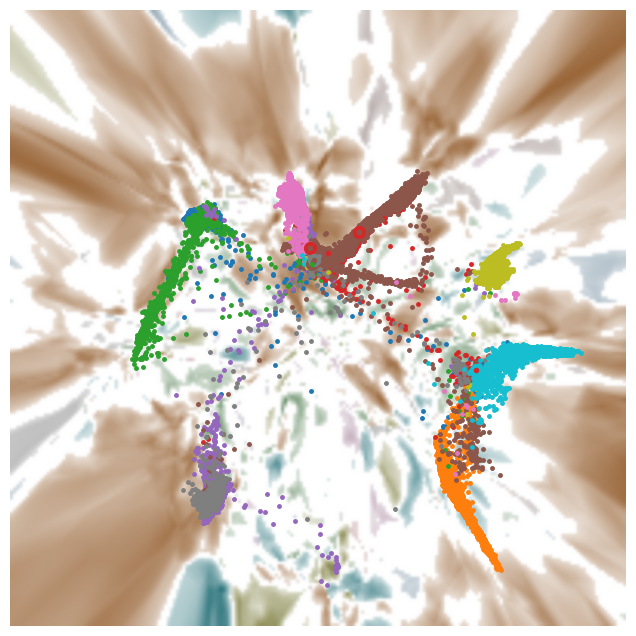

In [69]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
vis_model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=vis_model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)

def get_decision_view_grid(visualizer, epoch):

        x_min, y_min, x_max, y_max = visualizer.get_epoch_plot_measures(epoch)
        # create grid
        xs = np.linspace(x_min, x_max, 200)
        ys = np.linspace(y_min, y_max, 200)
        grid = np.array(np.meshgrid(xs, ys))
        grid = np.swapaxes(grid.reshape(grid.shape[0], -1), 0, 1)
        
        return grid

grid = get_decision_view_grid(vis,200)
bg = projector.batch_inverse(200, grid)
Z = torch.from_numpy(bg).float()
print(bg.shape)

# Create a placeholder for the transformed data
Z_trans = torch.empty_like(Z)



# Pass the new data through the trained model in batches
with torch.no_grad():
    for i in range(0, Z.size()[0], batch_size):
        batch_z = Z[i:i+batch_size]
        Z_trans[i:i+batch_size] = model(batch_z)



from AlignVis.visualizer import visualizer

vis = visualizer(ref_provider,ref_provider,I, Y_trans.detach().numpy(), projector,Z_trans.detach().numpy(), 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8327.85it/s]


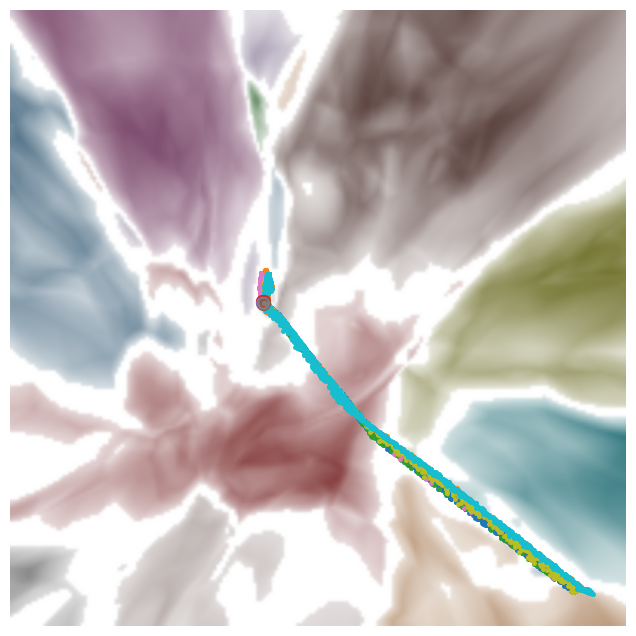

In [44]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from projects.deepdebugertool.DLVisDebugger.AlignVis.visualizerrr import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(tar_provider,I,I, Y_trans.detach().numpy(), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8884.36it/s]


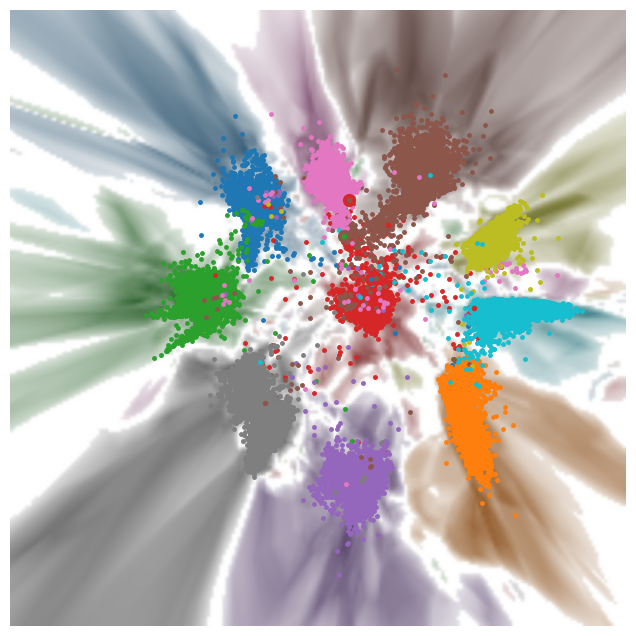

In [27]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
# from projects.deepdebugertool.DLVisDebugger.AlignVis.visualizerrr import visualizer
from representationTrans.trans_visualizer_border import visualizer
vis = visualizer(ref_provider,I,I, ref_train_data, projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))